# Speaker gender classification
## Master Student Assignment -- Swisscom
### By Johan Barthas

The goal of this notebook is to use different approaches to do a Speaker Gender Classification task using the `dev-clean` corpus from [LibriSpeech](http://www.openslr.org/12/).

For this task, we will:
* Explore the dataset to have a good sense of the kind of data we are dealing with. This will help us decide how we will extract a dataset from the corpus we are given.
* Generate a dataset using MFCC features which is a common way to generate features for Speech Recognition tasks. For general purpose, MFCC must be used cautiously because it's [very sensitive to noise](https://ieeexplore.ieee.org/document/7939548).
* Train a few models on this dataset with different approaches:
    * K-Nearest Neighbors
    * Support Vector Machines with RBF kernel
    * MultiLayer Perceptron
    * 1D Convolutional neural network with dense layers

### Loading libraries

In [20]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, List, Union
from tqdm.notebook import tqdm
from collections import defaultdict
from operator import itemgetter

import librosa

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset

plt.rcParams['figure.figsize'] = [10, 6]

## Exploring the dataset

### Introducing a few helper methods / class

We start this section by introducing a few helpers that will be used to generate our dataset. The features will be computed using `librosa.feature.mfcc` from the librosa Python library which allows us to directly read .FLAC files (format used in LibriSpeech dev-clean corpus).
__Note:__ Please read the docstring for more information on each function / class implemented.

In [21]:
def compute_mfcc(flac_path: Path, n_mfcc: int, hop_length: int,
                 n_fft: int) -> np.array:
    """Returns the mean of n_mfcc MFCC features for a given audio file.

    Args:
        flac_path (Path): Path of the audio file to process.
        n_mfcc (int): Number of features to extract.
        hop_length (int): Length of each frame we compute the MFCC on.
        n_fft (int): The length to compute the Fast Fourier Transform on.

    Returns:
        np.array: The mean of the n_mfcc MFCC features computed.
    """

    y, sr = librosa.load(flac_path)
    hop_length = hop_length
    n_fft = n_fft
    mfcc_result = librosa.feature.mfcc(y=y,
                                       sr=sr,
                                       hop_length=hop_length,
                                       n_fft=n_fft,
                                       n_mfcc=n_mfcc)

    # We take the mean over the sample, while not being robust
    # with noise concern, the cleaniness of our dataset allows 
    # to use it.
    mfcc_mean = np.mean(mfcc_result, axis=1)
    return mfcc_mean


def report(
    y_test: np.array, y_pred: np.array) -> Union[str, dict]:
    """[summary]

    Args:
        y_test (np.array): The test labels with binary values.
        y_pred (np.array): The predicted labels with binary values.
        output_dict (bool): Output is dict if True else a stringified version.

    Returns:
        Union[str, dict]: Either a string or a dict of the metrics
            from sklearn.metrics.classification_report.
    """
    labels_names = np.array([0, 1])
    target_names = ["F", "M"]
    return classification_report(y_test,
                                 y_pred,
                                 labels=labels_names,
                                 target_names=target_names)

In [22]:

DATA_PATH = "./data/LibriSpeech/"
LABELS = {"M": 1, "F": 0}


class Dataset:
    """ Class helping use extract both data and metadata from
        the dev-clean corpus."""
    def __init__(self, subset: str = "dev-clean", random_seed: int = 42):
        self.subset = subset
        self.chapters = None
        self.speakers = None
        self.merged_df = None
        self.random_seed = random_seed

    def get_metadata_df(self, name: str) -> pd.DataFrame:
        """Return the metadata datasets: 'chapters' and 'speakers' as
            as a pandas DataFrame.

        Args:
            name (str): 'chapters' or 'speakers'.

        Raises:
            NotImplementedError: Raised if metadata name is not recognised.

        Returns:
            pd.DataFrame: pandas DataFrame with schema dictionary:
                * chapters: (book_id, reader_id, minutes)
                * speakers: (reader_id, gender)
        """
        if name not in {"chapters", "speakers"}:
            raise NotImplementedError
        dict_skiprows = {"chapters": 13, "speakers": 11}
        dict_txt_name = {
            "chapters": "CHAPTERS.TXT",
            "speakers": "SPEAKERS.TXT"
        }
        txt_file = os.path.join(DATA_PATH, dict_txt_name[name])
        num_skiprows = dict_skiprows[name]

        if name == "chapters":
            if not isinstance(self.chapters, pd.DataFrame):
                df = pd.read_csv(txt_file,
                                 sep="|",
                                 skiprows=range(num_skiprows))
                df.rename(columns=lambda x: x.strip(), inplace=True)
                df.rename(columns={";ID": "ID"}, inplace=True)
                df["SUBSET"] = df["SUBSET"].str.strip()
                df = df[df["SUBSET"] == self.subset]
                df = df.astype({
                    "ID": int,
                    "READER": int,
                    "MINUTES": float
                },
                               copy=False)
                self.chapters = df[['ID', 'READER', 'MINUTES']]
            return self.chapters

        if not isinstance(self.speakers, pd.DataFrame):
            # For speakers, there are | to separate authors, thus we can
            # not use pd.read_csv but we can iterate the text file and collect
            # what we need.
            df = pd.DataFrame(columns=["ID", "GENDER"])
            with open(txt_file, "r") as f:
                i = 0
                for i, line in enumerate(f):
                    if i > num_skiprows:
                        data_split = line.split('|')
                        if data_split[2].strip() == "dev-clean":
                            data = {
                                "ID": int(float(data_split[0])),
                                "GENDER": str(data_split[1]).strip()
                            }
                            df.loc[i - num_skiprows] = data
                            i += 1
            self.speakers = df.astype({"ID": int, "GENDER": str}, copy=False)
        return self.speakers

    def create_df_dataset(self) -> pd.DataFrame:
        """Return a dataset from dev-clean.

        Returns:
            pd.DataFrame: Schema: (gender, book_id, reader_id, minutes)
        """
        if not isinstance(self.chapters, pd.DataFrame):
            self.get_metadata_df("chapters")

        if not isinstance(self.speakers, pd.DataFrame):
            self.get_metadata_df("speakers")

        if not isinstance(self.merged_df, pd.DataFrame):
            merged_df = pd.merge(self.speakers,
                                 self.chapters,
                                 how="inner",
                                 left_on="ID",
                                 right_on="READER")
            merged_df.rename(columns={"ID_y": "BOOK_ID"}, inplace=True)
            merged_df.drop(columns=["ID_x"], inplace=True)
            self.merged_df = merged_df
        return self.merged_df

    def _get_train_ids(self, test_ratio: float) -> List[int]:
        """Return the train ids obtained from sampling separately
            from male and female entries.

        Args:
            test_ratio (float): The ratio attributed to test data.

        Returns:
            List[int]: List of reader_id used for training.
        """
        mask_is_male = self.merged_df["GENDER"].str.strip() == "M"
        male_ids = list(
            self.merged_df[mask_is_male]['READER'].drop_duplicates())
        female_ids = list(
            self.merged_df[~mask_is_male]['READER'].drop_duplicates())
        # We reduce the outcome by 
        mask_male_train = np.random.choice(len(male_ids),
                                           int((1 - test_ratio) *
                                               len(male_ids)),
                                           replace=False)
        mask_female_train = np.random.choice(len(female_ids),
                                             int((1 - test_ratio) *
                                                 len(female_ids)),
                                             replace=False)
        return [male_ids[id] for id in mask_male_train
                ] + [female_ids[id] for id in mask_female_train]

    def np_dataset(
        self,
        n_mfcc: int = 20,
        hop_length: int = 128,
        n_fft: int = 512,
        test_ratio: float = 0.2
    ) -> Tuple[np.array, np.array, np.array, np.array]:
        """Generate a tuple (train_data, train_labels, test_data, test_labels)

        Args:
            n_mfcc (int, optional): Number of mels. Defaults to 20.
            hop_length (int, optional): Number of samples between successive frames. Defaults to 128.
            n_fft (int, optional): Length of the FFT window. Defaults to 512.
            test_ratio (float, optional): Test ratio from data. Defaults to 0.2.

        Raises:
            ValueError: Raised if test_ratio is not between 0 and 1.

        Returns:
            Tuple[np.array, np.array, np.array, np.array]: (train_data, train_labels, test_data, test_labels).
        """
        if not isinstance(self.merged_df, pd.DataFrame):
            self.create_df_dataset()
        train_data = []
        train_labels = []
        test_data = []
        test_labels = []
        length_dataset = len(self.merged_df.index)

        try:
            assert 0.0 <= test_ratio <= 1.0
        except:
            raise ValueError(
                "The value for test_ratio should be in [0.0, 1.0].")

        train_ids = self._get_train_ids(test_ratio=test_ratio)
        # print(train_ids)

        for tuple in tqdm(self.merged_df.itertuples(), total=length_dataset):
            reader_book_path = Path(
                os.path.join(DATA_PATH, "dev-clean", str(tuple[3]),
                             str(tuple[2])))
            supported_extensions = [
                ".flac",
            ]
            for file in reader_book_path.iterdir():
                if file.suffix in supported_extensions:
                    flac_path = file
                    mfcc_mean = compute_mfcc(flac_path,
                                             n_mfcc=n_mfcc,
                                             hop_length=hop_length,
                                             n_fft=n_fft)
                    if (tuple[3] in train_ids):
                        train_data.append(mfcc_mean)
                        train_labels.append(LABELS[tuple[1]])
                    else:
                        test_data.append(mfcc_mean)
                        test_labels.append(LABELS[tuple[1]])
        
        # Balance the dataset if not done, this approach is not the best
        # Since we might end up removing a speaker due to some speakers
        # having shorter utterances and thus more utterances.

        clean_train_data, clean_train_labels = Dataset.balance_np_dataset(
            train_data, train_labels
        )
        clean_test_data, clean_test_labels = Dataset.balance_np_dataset(
            test_data, test_labels
        )

        return clean_train_data, \
            clean_train_labels, \
                clean_test_data, \
                    clean_test_labels

    @staticmethod
    def balance_np_dataset(
        data: List[np.array],
        labels: List[int]
    ) -> Tuple[np.array, np.array]:
        """Return a (data, labels)
            balanced.
        
        Args:
            data (List[np.array]): MFCC features dataset.
            labels (List[np.array]): Labels.

        Returns:
            Tuple[np.array, np.array]: Balanced data and labels.
        """
        num_1 = sum(labels)
        clean_data = []
        clean_labels = []
        if not num_1 == len(labels) - num_1:
            objective = min(num_1, len(labels) - num_1)
            current_1 = 0
            current_0 = 0
            for data, label in zip(data, labels):
                if label == 0 and current_0 < objective:
                    clean_data.append(data)
                    clean_labels.append(label)
                    current_0 += 1
                elif label == 1 and current_1 < objective:
                    clean_data.append(data)
                    clean_labels.append(label)
                    current_1 += 1
        return np.array(clean_data), np.array(clean_labels)


### Insighs on the corpus metadata

A first insight from the dataset tells us that there are as much man than woman that are in this corpus.

In [23]:
dataset = Dataset()
speakers_df = dataset.get_metadata_df("speakers")
speakers_df.groupby('GENDER')['ID'].nunique()

GENDER
F    20
M    20
Name: ID, dtype: int64

Loading the chapters metadata

In [24]:
chapters_df = dataset.get_metadata_df("chapters")
chapters_df.head()

,ID,READER,MINUTES
230,4943,3752,2.59
231,4944,3752,5.47
371,8226,3536,3.59
407,9006,2902,5.37
408,9008,2902,2.72


### Number of minutes per speaker
We can see on the graph below that each speaker in the dev-clean corpus speaks equally. This is good news because we wouldn't want a bias introduced by an unbalanced dataset with one speaker talking way more than the others.

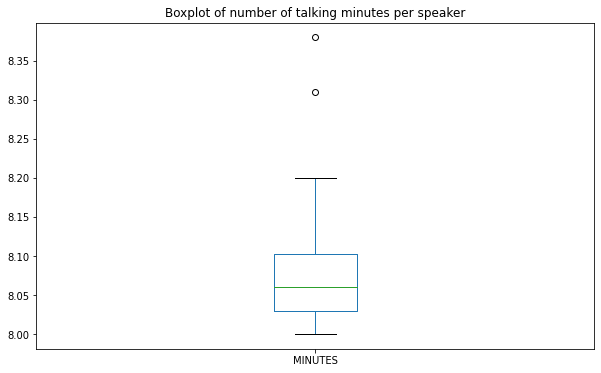

In [25]:
merged_df = dataset.create_df_dataset()
merged_df.groupby("READER")["MINUTES"].sum().plot.box()
plt.title("Boxplot of number of talking minutes per speaker")
plt.show()

Also, it is interest to have an equal number of minutes talked by each gender so we don't have a gender bias.

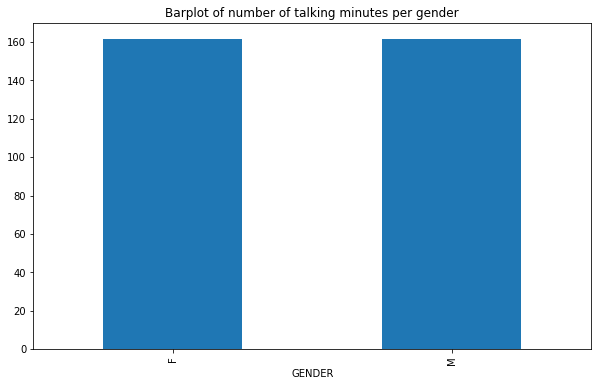

In [26]:
merged_df.groupby("GENDER")["MINUTES"].sum().plot.bar()
plt.title("Barplot of number of talking minutes per gender")
plt.show()

## Generate classification dataset
We now generate our classification dataset that we will be using afterward to assess our models.
The hyperparameters of this dataset generation are:
* n_mfcc: number of MFCC features, we select 36 as it led to good results
* sr: the sample rate of the FLAC file, used to compute the hop_length (see next)
* hop_duration: the duration to compute the MFCC features on for an audio file, we select 100 ms and it led to good result, we don't want it to be too short to reduce the effect of noise on it.
* n_fft: the number of values used to compute the Fast Fourier Transform, it showed good results and thus we chose 512.
* test_ratio: the ratio of data to go into the test set.

### Using our custom class to generate the classification dataset

In [27]:
n_mfcc = 36
sr = 22050
hop_duration = 0.1 # s
hop_length = round(hop_duration * sr)
n_fft = 512
test_ratio = 0.2

dataset_path = Path(f"./data/dataset_{n_mfcc}_{hop_length}_{n_fft}.npy")
if not dataset_path.is_file():
    train_data, y_train, test_data, y_test = dataset.np_dataset(n_mfcc = n_mfcc, hop_length = hop_length, n_fft=n_fft, test_ratio=test_ratio)
    with open(dataset_path, 'wb') as f:
        np.save(f, train_data)
        np.save(f, y_train)
        np.save(f, test_data)
        np.save(f, y_test)                                          
else:
    with open(dataset_path, 'rb') as f:
        train_data = np.load(f)
        y_train = np.load(f)
        test_data = np.load(f)
        y_test = np.load(f)

### Standardizing the dataset
We standardize our data as sklearn models expect standardized data to perform well. It's also good practice to standardize (or normalize) the data in order to facilitate the models to learn the underlying distribution without having weights that are excessively high.

__Note:__ We fit the sklearn StandardScaler on the whole data because we want the same preprocess on both the training set and testing set. 

In [28]:
scaler = StandardScaler()
scaler.fit(np.concatenate((train_data, test_data)))
X_train = scaler.transform(train_data)
X_test = scaler.transform(test_data)

In [29]:
print("X_train shape: ", X_train.shape, "X_test shape: ", X_test.shape)

X_train shape:  (2106, 36) X_test shape:  (524, 36)


## Assessing different models
### K-Nearest Neighbors
The first model we try is the K Nearest Neighbors algorithm which try to clusterize the data according to the number of neighbors we compute the distance from. Thus the distance metrics is very important here as well as a standardized dataset. We try odd numbers of neighbors because as we are in binary classification, we want to avoid tied votes.

In [30]:
max_num_neighbors = 41
best_num_neighbors = 3
best_accuracy = 0
for num_neighbors in range(3, max_num_neighbors + 1, 2):
    KNN = KNeighborsClassifier(num_neighbors)
    KNN.fit(X_train, y_train)
    accuracy = KNN.score(X_test, y_test)
    if accuracy > best_accuracy:
        print(f"New best test accuracy {round(accuracy, 4)} with {num_neighbors} neighbors.")
        best_num_neighbors = num_neighbors
        best_accuracy = accuracy

New best test accuracy 0.7863 with 3 neighbors.
New best test accuracy 0.7977 with 41 neighbors.


In [31]:
print(f"The best model within the range (2, {max_num_neighbors+1}) as number of neighbors to compute for the model is reached with {best_num_neighbors} neighbors and the report is below.")
KNN = KNeighborsClassifier(best_num_neighbors)
y_pred_knn = KNN.fit(X_train, y_train).predict(X_test)
print(report(y_test, y_pred_knn))

The best model within the range (2, 42) as number of neighbors to compute for the model is reached with 41 neighbors and the report is below.
              precision    recall  f1-score   support

           F       0.80      0.79      0.80       262
           M       0.80      0.80      0.80       262

    accuracy                           0.80       524
   macro avg       0.80      0.80      0.80       524
weighted avg       0.80      0.80      0.80       524



### Support Vector Machines
The second model we try is a model from the Support vector machines group. This algorithm tries to draw an hyperplane between the two categories to maximize the margin. However it's very likely that we don't have linear data. We choose an RBF kernel as it usually outperforms polynomial and linear kernel due to the increased size of the function class.

In [32]:
y_pred_svm = SVC(kernel="rbf").fit(X_train, y_train).predict(X_test)
print(report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           F       0.79      0.86      0.83       262
           M       0.85      0.77      0.81       262

    accuracy                           0.82       524
   macro avg       0.82      0.82      0.82       524
weighted avg       0.82      0.82      0.82       524



### Multi Layer Perceptron
The third model we try is a two layer perceptron. This is a classic model of feedforward neural networks composed of linear layers. Here we decide to make the first layer number of units $n1$ vary between 1 and $n_{mfcc}=36$ and the second layer vary from 1 to $n1$. We pick the L2 penalty to be $\alpha=10^{-5}$. With more computational power, we would do a grid search on the L2 penalty, the learning rate, and the batch size.

In [33]:
max_num_hidden_units = n_mfcc
layer_options = [(i, j) for i in range(1, max_num_hidden_units) for j in range(1, i+1)]
best_accuracy = 0
best_layer_opt = (1,1)
for layer_opt in layer_options:
    mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(layer_opt[0], layer_opt[1]), random_state=42)
    mlp.fit(X_train, y_train)
    accuracy = mlp.score(X_test, y_test)
    if accuracy > best_accuracy:
        best_layer_opt = layer_opt
        best_accuracy = accuracy
        print(f"New best test accuracy {round(accuracy, 4)} with layer_opt=({layer_opt}).")

New best test accuracy 0.8511 with layer_opt=((1, 1)).
New best test accuracy 0.8893 with layer_opt=((3, 1)).
New best test accuracy 0.8989 with layer_opt=((4, 3)).
New best test accuracy 0.9141 with layer_opt=((5, 3)).


In [34]:
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(best_layer_opt[0], best_layer_opt[1]), random_state=42)
mlp.fit(X_train, y_train)
print(f"Best number of hidden units for a 2perceptron: first layer: {best_layer_opt[0]}, second layer: {best_layer_opt[1]} ")
print(report(y_test, mlp.predict(X_test)))

Best number of hidden units for a 2perceptron: first layer: 5, second layer: 3 
              precision    recall  f1-score   support

           F       0.92      0.91      0.91       262
           M       0.91      0.92      0.91       262

    accuracy                           0.91       524
   macro avg       0.91      0.91      0.91       524
weighted avg       0.91      0.91      0.91       524



### 1D Convolutional NN with Linear Layers
As fourth and last model that we try, we design a 1D-Convolutional Neural Network using Pytorch as framework.

The architecture we decide to go for is the following:
* input_shape: (batch_size, 1, n_mfcc) so that we will do convolution on the features trying to find some underlying distributions
* Conv1d: (in_channels = 1, out_channels = 50, kernel_size = 9)  we selected the two parameters arbitrarly but a more rigorous approach would be to perform a grid search.
* Batch Normalization: Smoothing of the objective function and [faster convergence](https://arxiv.org/abs/1805.11604).
* Dense: ((n_mfcc - Conv1d.kernel_size + 1) * Conv1d.out_channels) so that we take what outputs Conv1d and do a dense layer.
* Dropout: 0.8 so that we avoid overfitting.
* Layer: ((n_mfcc - Conv1d.kernel_size + 1) * Conv1d.out_channels, 1)
* output_shape: (batch_size, 1)

The activation functions are leaky relu because the inputs can be negative and we use as optimizer Adam with a learning rate $l_r = 10^{-4}$ and a L2 penalty of $decay = 10^{-4}$. The loss function we use is the Binary Cross-Entropy (BCE) loss which is appropriate for binary classification tasks.

After a few epochs, we get an accuracy of $\approx 90\%$ which outperforms except for the multi-perceptron.

#### Creating the Torch Datasets

In [42]:
train_inputs = torch.from_numpy(X_train).type(torch.float32)
train_targets = torch.from_numpy(y_train).type(torch.float32)
train_dataset = TensorDataset(train_inputs, train_targets)

test_inputs = torch.from_numpy(X_test).type(torch.float32)
test_targets = torch.from_numpy(y_test).type(torch.float32)
test_dataset = TensorDataset(test_inputs, test_targets)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=12, drop_last=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                          shuffle=False, num_workers=1)


#### Defining the torch model

In [43]:
class CNNClassifier(nn.Module):
    def __init__(self, n_mfcc: int, out_channels: int = 50, kernel_size: int = 9) -> None:
        super(CNNClassifier, self).__init__()
        self.n_mfcc = n_mfcc
        self.out_channels = out_channels
        self.kernel_size = kernel_size 
        self.conv1 = nn.Conv1d(1, out_channels=out_channels, kernel_size=kernel_size)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.den1 = nn.Linear((self.n_mfcc - self.kernel_size + 1) * self.out_channels, (self.n_mfcc - self.kernel_size + 1) * self.out_channels)
        self.lin1 = nn.Linear((self.n_mfcc - self.kernel_size + 1) * self.out_channels, 1)
        self.dropout = nn.Dropout(0.8) # extreme value to avoid overfitting
        self.sigmoid = nn.Sigmoid()
        self.Lrelu = torch.nn.LeakyReLU()
        
    def forward(self, x):
        x = self.Lrelu(self.conv1(x))
        x = self.bn1(x)
        x = x.view(-1, (self.n_mfcc - self.kernel_size + 1) * self.out_channels)
        x = self.Lrelu(self.den1(x))
        x = self.dropout(x)
        x = self.Lrelu(self.lin1(x))
        x = self.sigmoid(x)
        return x

#### Defining training and evaluating for the model

In [44]:
def train(
    model,
    trainloader: torch.utils.data.DataLoader,
    n_epochs: int,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.BCELoss,
    epochs_before_eval: int = 1
):
    """ Train the 1D-CNN using a trainloader and a max num. of epochs. """
    best_test_accuracy = 0
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if epoch % epochs_before_eval == 0 and i == 0:
                test_accuracy = eval(model, testloader)
                # print(accuracy)
                if best_test_accuracy < test_accuracy:
                    print(f"New best test accuracy at epoch {epoch}: {test_accuracy}.")
                    best_test_accuracy = test_accuracy
                else:
                    print('Finished Training, test accuracy started dropping.')
                    return model

            running_loss += loss.item()
        # Log the loss to tensorboard
        writer.add_scalar('Loss', running_loss, epoch)
    print('Finished Training')
    return model

def eval(
    model,
    testloader: torch.utils.data.DataLoader
):
    """ Freeze the model and return accuracy from the testloader provided. """
    with torch.no_grad():
        total_correct = 0
        total_predictions = 0
        for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            predictions = (outputs>0.5).float()
            correct = (predictions == labels).float().sum()
            total_predictions += predictions.shape[0]
            total_correct += correct
        return total_correct/total_predictions

def make_report(model, testloader: torch.utils.data.DataLoader):
    """Evaluate the model and calls our report method.
    """
    y_pred_cnn = []
    y_test_cnn = []
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.unsqueeze(1)
            outputs = torch.squeeze(model(inputs), dim=1).cpu().numpy()
            labels = labels.cpu().numpy()
            for prediction in outputs:
                y_pred_cnn.append(int(prediction > 0.5))
            for label in labels:
                y_test_cnn.append(label)
    return report(y_test_cnn, y_pred_cnn)

In [45]:
# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Create model with parameters for the conv1D layer
model = CNNClassifier(n_mfcc=n_mfcc, out_channels=50, kernel_size=9)
# Put model to gpu if possible
model.to(device)
# Select max number of epochs
n_epochs = 20
# Initialize criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
# Initialize tensorboard
writer = SummaryWriter()
# Train model
model = train(model, trainloader, n_epochs, optimizer, criterion)
# Get and print report
cnn_report = make_report(model, testloader)
print("\n" + cnn_report)

New best test accuracy at epoch 0: 66.89312744140625.
New best test accuracy at epoch 1: 87.4542007446289.
New best test accuracy at epoch 2: 88.1259536743164.
Finished Training, test accuracy started dropping.

              precision    recall  f1-score   support

           F       0.93      0.86      0.89       262
           M       0.87      0.94      0.90       262

    accuracy                           0.90       524
   macro avg       0.90      0.90      0.90       524
weighted avg       0.90      0.90      0.90       524



## Conclusion
We tried different models to tackle the speaker gender classification problem and we used models with an increased complexity which led to better results. But although we saw improvement, the complexity of our model increased drastically and this trade-off might not be always justified since it's way more time consuming.

Besides, also it was good to use the same dataset to be able to compare them. We could have done without the MFCC features with the deep learning approach. Indeed, usually deep learning is used to avoid spending time on feature engineering, and even though it's very usual to use MFCC features in Speech Recognition, for a simple task like this one. I believe that a CNN would have been able to classify a signal directly from the time series.